<a href="https://colab.research.google.com/github/vaibhavb/zero-to-one-datascience-to-ai/blob/main/004_Logistic_Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Kaggle & Data Setup

In [13]:
import kagglehub
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
kagglehub.login()


In [2]:
titanic_path = kagglehub.competition_download('titanic')
train_df = pd.read_csv(titanic_path + "/train.csv")
df_processed = train_df.copy()
df_processed.drop('Cabin', axis=1, inplace=True)
median_age = df_processed['Age'].median() #median
df_processed.fillna({'Age': median_age}, inplace=True)
mode_embarked = df_processed['Embarked'].mode()[0] #mode returns a series so we take first
df_processed.fillna({'Embarked': mode_embarked}, inplace=True)
df_model_ready = df_processed.copy()
df_model_ready = pd.get_dummies(df_model_ready, columns=['Sex'], prefix='Sex', drop_first=True)
df_model_ready = pd.get_dummies(df_model_ready, columns=['Embarked'], prefix='Embarked', drop_first=True)
columns_to_drop_for_model = ['Name', 'Ticket', 'PassengerId', 'SibSp', 'Parch']
df_model_ready.drop(columns=columns_to_drop_for_model, axis=1, inplace=True)
potential_numerical_cols = df_model_ready.select_dtypes(include=np.number).columns.tolist()
cols_to_exclude_from_scaling = ['Survived']
numerical_cols_for_scaling = [col for col in potential_numerical_cols if col not in cols_to_exclude_from_scaling]
scaler = StandardScaler()
df_model_ready[numerical_cols_for_scaling] = scaler.fit_transform(df_model_ready[numerical_cols_for_scaling])
print("\nDescriptive stats of scaled features (should have mean ~0, std ~1):")
print(df_model_ready[numerical_cols_for_scaling].describe())


Descriptive stats of scaled features (should have mean ~0, std ~1):
             Pclass           Age          Fare
count  8.910000e+02  8.910000e+02  8.910000e+02
mean  -8.772133e-17  2.272780e-16  3.987333e-18
std    1.000562e+00  1.000562e+00  1.000562e+00
min   -1.566107e+00 -2.224156e+00 -6.484217e-01
25%   -3.693648e-01 -5.657365e-01 -4.891482e-01
50%    8.273772e-01 -1.046374e-01 -3.573909e-01
75%    8.273772e-01  4.333115e-01 -2.424635e-02
max    8.273772e-01  3.891554e+00  9.667167e+00


In [3]:
X = df_model_ready.drop('Survived', axis=1)
y = df_model_ready['Survived']
X_train, X_val, y_train, y_val = train_test_split(
    X, y,
    test_size=0.2,    # 20% for validation, 80% for training
    random_state=42,  # The answer to life, the universe, and everything - for consistency
    stratify=y        # Important for classification if y has more than 1 class and is not empty
)
print("\nShapes of the resulting data splits:")
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_val shape: {X_val.shape}, y_val shape: {y_val.shape}")



Shapes of the resulting data splits:
X_train shape: (712, 6), y_train shape: (712,)
X_val shape: (179, 6), y_val shape: (179,)


# Building Blocks

## Convert Data to NumPy Arrays
Our X_train, X_val, y_train, y_val are Pandas DataFrames/Series. We need them as NumPy arrays for our scratch implementation.


In [4]:
X_train_np = X_train.to_numpy()
X_val_np = X_val.to_numpy()
y_train_np = y_train.to_numpy().reshape(-1, 1) # Reshape y to be a column vector (m, 1)
y_val_np = y_val.to_numpy().reshape(-1, 1)   # Reshape y to be a column vector (m, 1)

print(f"X_train_np shape: {X_train_np.shape}, y_train_np shape: {y_train_np.shape}")
print(f"X_val_np shape: {X_val_np.shape}, y_val_np shape: {y_val_np.shape}")


X_train_np shape: (712, 6), y_train_np shape: (712, 1)
X_val_np shape: (179, 6), y_val_np shape: (179, 1)


## Sigmoid Function Implementation

In [14]:
def sigmoid(z):
    """
    Compute the sigmoid of z.
    Arguments:
    z -- A scalar or numpy array of any size.
    Return:
    s -- sigmoid(z)
    """
    # Clip z to avoid overflow in exp for very large negative z, and underflow for large positive z
    # Although for exp(-z), overflow happens for large negative z.
    # np.exp is generally robust, but direct large values can be an issue.
    # For practical purposes, sigmoid(z) for z < -700 is ~0 and for z > 700 is ~1.
    # However, direct exp(-z) can overflow for z like -1000.
    # A common practice is to clip z or handle large values.
    # For simplicity here, we'll assume z is within reasonable bounds for np.exp.
    # Ensure z is a numpy array
    z = np.array(z, dtype=np.float64)
    # Clip z to prevent overflow
    z = np.clip(z, -500, 500)
    s = 1 / (1 + np.exp(-z))
    return s

# Test sigmoid
print("\nSigmoid function examples:")
test_z_values = np.array([-10, -1, 0, 1, 10])
print(f"sigmoid({test_z_values}) = {sigmoid(test_z_values)}")


Sigmoid function examples:
sigmoid([-10  -1   0   1  10]) = [4.53978687e-05 2.68941421e-01 5.00000000e-01 7.31058579e-01
 9.99954602e-01]


## Initialize Parameters (Weights W and Bias b)
- $W$: A vector of weights, one for each feature. Initialize to zeros or small random numbers. For simplicity and to match many introductory examples, we'll use zeros.
- $b$: A scalar bias term. Initialize to zero.

In [15]:
def initialize_parameters_logistic(num_features):
    """
    Initializes weights as a vector of zeros and bias as 0.
    Argument:
    num_features -- number of features in the input data (integer)
    Returns:
    W -- initialized vector of shape (num_features, 1)
    b -- initialized scalar (float)
    """
    W = np.zeros((num_features, 1)) # Column vector
    b = 0.0
    return W, b

# Example initialization
if 'X_train_np' in locals() and X_train_np.size > 0 :
    example_num_features = X_train_np.shape[1]
    W_example, b_example = initialize_parameters_logistic(example_num_features)
    print(f"\nExample initialized W shape: {W_example.shape}")
    print(f"Example initialized b: {b_example}")



Example initialized W shape: (6, 1)
Example initialized b: 0.0


## Forward Propagation: Compute Hypothesis and Cost
* **Linear Combination:** $Z = X \cdot W + b$
    * If $X$ is $(m, n_f)$ (m samples, $n_f$ features) and $W$ is $(n_f, 1)$, then $X \cdot W$ is $(m, 1)$.
* **Activation (Hypothesis):** $A = \sigma(Z)$
    * This $A$ will be our predicted probabilities, shape $(m, 1)$.
* **Cost Function (Binary Cross-Entropy or Log Loss):**
    This measures how "wrong" our predictions are. For $m$ training examples:
    $$J(W,b) = -\frac{1}{m} \sum_{i=1}^{m} [y^{(i)}\log(a^{(i)}) + (1-y^{(i)})\log(1-a^{(i)})]$$
    where $a^{(i)}$ is the activation (predicted probability) for example $i$, and $y^{(i)}$ is the true label.

In [16]:
def forward_propagation_logistic(X, Y, W, b):
    """
    Implements the forward propagation to calculate predictions and cost.
    Arguments:
    X -- data of size (m_samples, n_features)
    Y -- true "label" vector (0 or 1) of size (m_samples, 1)
    W -- weights, a numpy array of size (n_features, 1)
    b -- bias, a scalar
    Returns:
    A -- activations (predicted probabilities), vector of shape (m_samples, 1)
    cost -- binary cross-entropy cost
    """
    m = X.shape[0] # Number of samples

    # Linear step
    Z = np.dot(X, W) + b  # Z will have shape (m, 1)

    # Activation step
    A = sigmoid(Z)       # A will have shape (m, 1)

    # Cost calculation
    # Add a small epsilon for numerical stability to avoid log(0) or log(1-1)
    epsilon = 1e-15
    cost = (-1/m) * np.sum(Y * np.log(A + epsilon) + (1 - Y) * np.log(1 - A + epsilon))
    cost = np.squeeze(cost) # Ensure cost is a scalar, not an array with one element

    return A, cost

## Backward Propagation: Compute Gradient
This step calculates the derivatives (gradients) of the cost function with respect to $W$ and $b$. These tell us how to update $W$ and $b$ to reduce the cost.
* $dZ = A - Y$ (Derivative of cost w.r.t $Z$, shape $(m, 1)$)
* $dW = \frac{1}{m} X^T \cdot dZ$ (Derivative of cost w.r.t $W$, shape $(n_f, 1)$)
* $db = \frac{1}{m} \sum_{i=1}^{m} (A - Y)^{(i)}$ (Derivative of cost w.r.t $b$, scalar)

In [17]:
def backward_propagation_logistic(X, Y, A):
    """
    Implements backward propagation to calculate gradients.
    Arguments:
    X -- data of size (m_samples, n_features)
    Y -- true "label" vector (0 or 1) of size (m_samples, 1)
    A -- activations (predictions) from forward_propagation, shape (m_samples, 1)
    Returns:
    dW -- gradient of the cost with respect to W, shape (n_features, 1)
    db -- gradient of the cost with respect to b, scalar
    """
    m = X.shape[0] # Number of samples

    dZ = A - Y  # Shape (m, 1)
    dW = (1/m) * np.dot(X.T, dZ) # X.T is (n_f, m), dZ is (m, 1) -> dW is (n_f, 1)
    db = (1/m) * np.sum(dZ)      # Sum over all samples

    return dW, db

## Optimization: Gradient Descent Update Rule
Update the parameters $W$ and $b$ in the opposite direction of their gradients to minimize the cost.
* $W = W - \alpha \cdot dW$
* $b = b - \alpha \cdot db$
Where $\alpha$ is the **learning rate**, a hyperparameter that controls the step size.

In [18]:
def update_parameters_logistic(W, b, dW, db, learning_rate):
    """
    Updates parameters using the gradient descent rule.
    Arguments:
    W, b -- parameters
    dW, db -- gradients
    learning_rate -- alpha
    Returns:
    W, b -- updated parameters
    """
    W = W - learning_rate * dW
    b = b - learning_rate * db
    return W, b


# Training the Logistic Regression Model
Lets combine all of the above

In [19]:
def logistic_regression_model_scratch(X_train, Y_train, num_iterations=2000, learning_rate=0.01, print_cost_every=100):
    """
    Builds and trains the logistic regression model from scratch.
    Arguments:
    X_train -- training data, shape (m_samples, n_features)
    Y_train -- training labels, shape (m_samples, 1)
    num_iterations -- number of iterations for gradient descent
    learning_rate -- learning rate for gradient descent
    print_cost_every -- print cost at this interval
    Returns:
    parameters -- dictionary containing final W and b
    costs -- list of costs recorded during training
    """
    if X_train.size == 0 or Y_train.size == 0:
        print("Error: Training data is empty. Cannot train model.")
        return {"W": None, "b": None}, []

    num_features = X_train.shape[1]
    W, b = initialize_parameters_logistic(num_features)
    costs = []

    for i in range(num_iterations):
        # Forward propagation
        A, cost = forward_propagation_logistic(X_train, Y_train, W, b)

        # Backward propagation
        dW, db = backward_propagation_logistic(X_train, Y_train, A)

        # Update parameters
        W, b = update_parameters_logistic(W, b, dW, db, learning_rate)

        # Record and print cost
        if i % print_cost_every == 0:
            costs.append(cost)
            print(f"Cost after iteration {i}: {cost:.4f}")
        if i == num_iterations - 1: # Also print final cost
             if i % print_cost_every != 0: # Avoid double printing if last iter is a print_cost_every iter
                costs.append(cost)
                print(f"Cost after iteration {i}: {cost:.4f}")

    parameters = {"W": W, "b": b}
    return parameters, costs

## Test the model

In [20]:
# prompt: add simple test case for logistic_regression_model_scratch

# Simple test case for logistic_regression_model_scratch
# Create some dummy data
X_dummy = np.array([[0.5, -1.0], [1.2, 0.5], [-0.8, 2.0], [-0.1, -0.5]]) # Shape (4, 2)
# Assign labels that would be 'learnable' by a simple model, e.g., based on the first feature
y_dummy = np.array([[0], [1], [0], [0]]) # Shape (4, 1)

print("\n--- Running simple test case for logistic_regression_model_scratch ---")
print(f"Dummy X shape: {X_dummy.shape}, Dummy y shape: {y_dummy.shape}")

# Run the training function on the dummy data
# Use fewer iterations and a slightly different learning rate for the test
test_parameters, test_costs = logistic_regression_model_scratch(
    X_dummy, y_dummy, num_iterations=500, learning_rate=0.1, print_cost_every=100
)

print("\nTest Case Results:")
print(f"Final W: {test_parameters['W']}")
print(f"Final b: {test_parameters['b']}")
print(f"Final Cost: {test_costs[-1] if test_costs else 'N/A'}")

# Basic checks on the output
assert test_parameters['W'] is not None and test_parameters['W'].shape == (X_dummy.shape[1], 1)
assert isinstance(test_parameters['b'], (float, int))
assert len(test_costs) > 0

print("--- Simple test case finished ---")



--- Running simple test case for logistic_regression_model_scratch ---
Dummy X shape: (4, 2), Dummy y shape: (4, 1)
Cost after iteration 0: 0.6931
Cost after iteration 100: 0.2744
Cost after iteration 200: 0.1635
Cost after iteration 300: 0.1150
Cost after iteration 400: 0.0883
Cost after iteration 499: 0.0717

Test Case Results:
Final W: [[3.53043003]
 [1.32151442]]
Final b: -2.6669784886694536
Final Cost: 0.07166276677315697
--- Simple test case finished ---


## Train the model


--- Training Logistic Regression Model (From Scratch) ---
Cost after iteration 0: 0.6931
Cost after iteration 100: 0.5038
Cost after iteration 200: 0.4754
Cost after iteration 300: 0.4611
Cost after iteration 400: 0.4532
Cost after iteration 499: 0.4486

--- Training Complete ---
Final W (head): [[-0.8752240305117448 -0.4307818844099717 0.11002484069278844
  -1.9949733554143212 0.34505604209858426]]
Final b: 0.7056


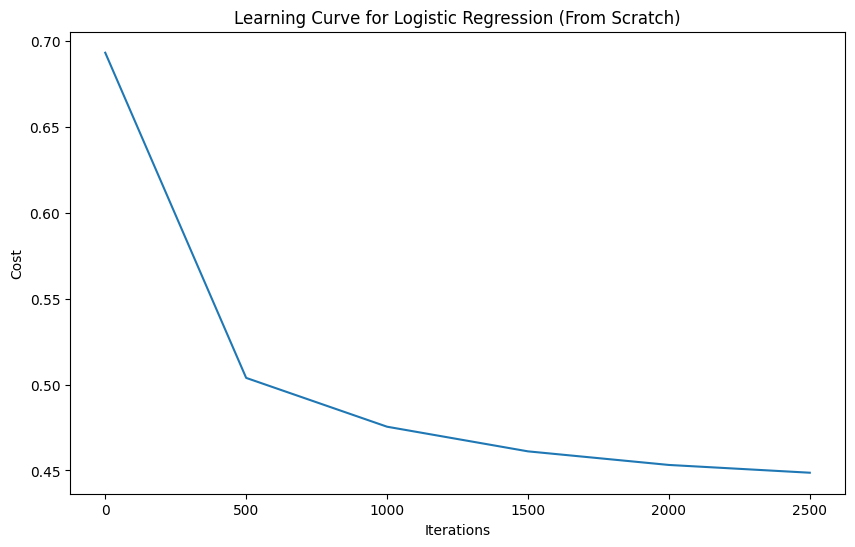

In [21]:
# Train the model (using X_train_np and y_train_np from earlier)
trained_parameters_scratch = {"W": None, "b": None} # Initialize to handle potential errors
costs_history_scratch = []

if 'X_train_np' in locals() and X_train_np.size > 0 and 'y_train_np' in locals() and y_train_np.size > 0:
    print("\n--- Training Logistic Regression Model (From Scratch) ---")
    trained_parameters_scratch, costs_history_scratch = logistic_regression_model_scratch(
        X_train_np, y_train_np,
        num_iterations=500, # Increased iterations
        learning_rate=0.1,  # Experiment with learning rate
        print_cost_every=100
    )

    if trained_parameters_scratch["W"] is not None:
        print("\n--- Training Complete ---")
        print(f"Final W (head): {trained_parameters_scratch['W'][:5].T if trained_parameters_scratch['W'].size > 0 else 'N/A'}")
        print(f"Final b: {trained_parameters_scratch['b']:.4f}")

        # Plot the learning curve (cost vs. iterations)
        plt.figure(figsize=(10,6))
        # X-axis for plot should match iterations where cost was recorded
        plot_iterations = np.arange(0, len(costs_history_scratch)) * 500
        plt.plot(plot_iterations, costs_history_scratch)
        plt.ylabel('Cost')
        plt.xlabel(f'Iterations')
        plt.title('Learning Curve for Logistic Regression (From Scratch)')
        plt.show() # Ensure plot is displayed
    else:
        print("Training did not complete successfully.")
else:
    print("\nCannot train model: X_train_np or y_train_np is not defined or empty.")

# Make Predictions
Use the learned $W$ and $b$ to predict on new data.


In [22]:
def predict_logistic_scratch(X, W, b, threshold=0.5):
    """
    Predicts binary labels (0 or 1) using learned logistic regression parameters.
    Arguments:
    X -- data to predict on, shape (m_samples, n_features)
    W, b -- learned parameters
    threshold -- probability threshold for classifying as 1
    Returns:
    Y_predictions -- numpy array of shape (m_samples, 1) with 0/1 predictions
    """
    if W is None or b is None or X.size == 0:
        print("Error: Model parameters or data missing for prediction.")
        return np.array([]) # Return empty array or handle error appropriately

    m = X.shape[0]
    Y_predictions = np.zeros((m, 1)) # Initialize predictions

    # Compute activations (probabilities)
    Z = np.dot(X, W) + b
    A = sigmoid(Z)

    # Convert probabilities to 0/1 predictions
    Y_predictions = (A >= threshold).astype(int) # Boolean to int

    return Y_predictions


## Try it

In [23]:
if trained_parameters_scratch["W"] is not None and \
   'X_train_np' in locals() and X_train_np.size > 0 and \
   'X_val_np' in locals() and X_val_np.size > 0 and \
   'y_train_np' in locals() and y_train_np.size > 0 and \
   'y_val_np' in locals() and y_val_np.size > 0:

    W_final_scratch = trained_parameters_scratch["W"]
    b_final_scratch = trained_parameters_scratch["b"]

    Y_pred_train_scratch = predict_logistic_scratch(X_train_np, W_final_scratch, b_final_scratch)
    Y_pred_val_scratch = predict_logistic_scratch(X_val_np, W_final_scratch, b_final_scratch)

    if Y_pred_train_scratch.size > 0 and Y_pred_val_scratch.size > 0:
        # Calculate Accuracy
        # Accuracy = (Number of correct predictions) / (Total number of predictions)
        train_accuracy_scratch = np.mean(Y_pred_train_scratch == y_train_np) * 100
        val_accuracy_scratch = np.mean(Y_pred_val_scratch == y_val_np) * 100

        print(f"\n--- From Scratch Model Performance ---")
        print(f"Training Accuracy: {train_accuracy_scratch:.2f}%")
        print(f"Validation Accuracy: {val_accuracy_scratch:.2f}%")
    else:
        print("Predictions could not be made or resulted in empty arrays.")
else:
    print("\nCannot make predictions: Model was not trained successfully or necessary data (X_train_np, X_val_np, y_train_np, y_val_np) is missing.")



--- From Scratch Model Performance ---
Training Accuracy: 80.34%
Validation Accuracy: 77.09%
